# Create Figure 2 for KRAS cis effect

This notebook creates a boxplot for the cis effect of KRAS missense mutations in 3 cancers. These 3 cancers were chosen because they have enough samples with KRAS missense mutations to do a t-test. 

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u
import plot_utils as p

Functions:

format_df prepares a data frame with KRAS proteomics and KRAS mutation type from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [2]:
# Returns a dataframe with proteomics and mutation type

def format_df(cancer_object, gene_in = 'KRAS', utils = u):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    mut_type['Mutation'].where(mut_type['Mutation'] != 'Missense_Mutation', 'Missense', inplace = True) # replace when false
    mut_type['Mutation'].where(mut_type['Mutation'] != 'nonsynonymous SNV', 'Missense', inplace = True)
    
    # Keep only tumor samples from proteomics
    prot_and_mutations = cancer_object.join_omics_to_mutations(
        mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = gene_in)
    prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples

    # Reduce a multiindex 
    if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
        prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)

    # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
    mut_type = mut_type[['Mutation']] 
    prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
    merged = prot_df.join(mut_type)

    # Keep only Wildtype and deletion
    compare = ['Wildtype_Tumor','Missense']
    get = merged['Mutation'].isin(compare)
    mut_wt = merged[get]

    return mut_wt


In [3]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Step 1: Create data frames with KRAS missense mutations and Proteomics

Each cancer needs a data frame containing only samples that have KRAS missense mutations or KRAS wildtype tumors and KRAS proteomics.

First, load in cancer data sets from cptac.

In [4]:
en = cptac.Endometrial()
l = cptac.Luad()
col = cptac.Colon()

Next, use format_df to create the specific data frame for each cancer. Use wrap_ttest to test KRAS missense vs. wildtype. 

# Luad

In [5]:
gene = 'KRAS'
l_mut_wt = format_df(l, gene)
l_pval = u.wrap_ttest(l_mut_wt, 'Mutation', [gene+'_proteomics'], return_all = True)
lp = l_pval.P_Value[0]
l_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 76 samples for the KRAS gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 178 samples for the KRAS gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1

,Comparison,P_Value
0,KRAS_proteomics,0.114481


# Colon

In [6]:
c_mut_wt = format_df(col, gene)
c_pval = u.wrap_ttest(c_mut_wt, 'Mutation', ['KRAS_proteomics'], return_all = True)
cp = c_pval.P_Value[0]
c_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 71 samples for the KRAS gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
cptac warning: In joining the somatic_mutation table, no mutati

,Comparison,P_Value
0,KRAS_proteomics,0.01079


# Endometrial

In [7]:
e_mut_wt = format_df(en, gene)
e_pval = u.wrap_ttest(e_mut_wt, 'Mutation', ['KRAS_proteomics'], return_all = True)
ep = e_pval.P_Value[0]
e_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 64 samples for the KRAS gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 113 samples for the KRAS gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1

,Comparison,P_Value
0,KRAS_proteomics,0.005531


# Step 2: Create a long dataframe for the boxplot

The boxplot will take three columns: Proteomics, Mutation, and Cancer. We need to append all the individual cancer dfs into one long pancancer df. 

First create the Cancer column.

In [8]:
l_mut_wt = l_mut_wt.assign(cancer = 'Luad')
c_mut_wt = c_mut_wt.assign(cancer = 'Colon')
e_mut_wt = e_mut_wt.assign(cancer = 'Endometrial')

Next append the dfs.

In [9]:
df = l_mut_wt.append(c_mut_wt)
df2 = df.append(e_mut_wt)
df2

Name,KRAS_proteomics,Mutation,cancer
Patient_ID,,,
C3L-00009,NaN,Wildtype_Tumor,Luad
C3L-00083,-0.3416,Wildtype_Tumor,Luad
C3L-00094,0.5142,Missense,Luad
C3L-00095,-0.9424,Wildtype_Tumor,Luad
C3L-00140,-0.7216,Wildtype_Tumor,Luad
...,...,...,...
C3N-01520,0.6620,Missense,Endometrial
C3N-01521,-0.4350,Missense,Endometrial
C3N-01537,-0.1370,Wildtype_Tumor,Endometrial


# Step 3: Create the Pancancer Boxplot

p-values: 

Luad 0.11448064454827266 

Colon 0.010790315848871903 

Endo 0.005530656769015996 



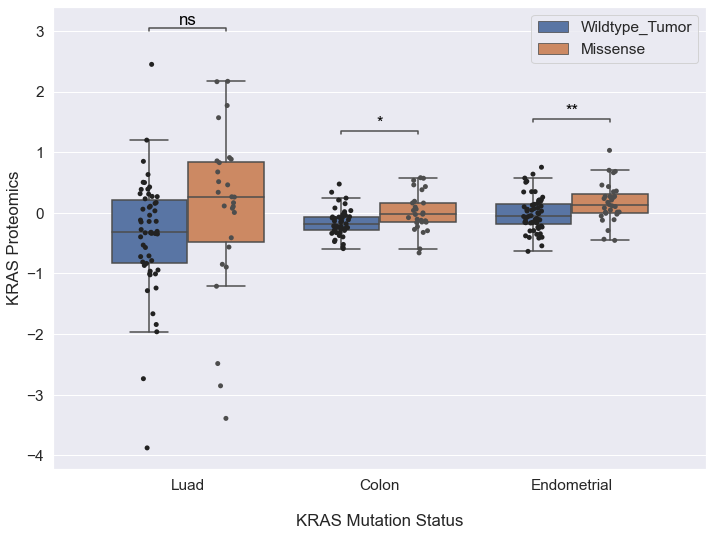

In [10]:
# cis plot
gene = 'KRAS'
plt.rcParams['figure.figsize']=(11.7, 8.5) #size of plot
sns.set(font_scale = 1.4)

boxplot = sns.boxplot(x='cancer', y=gene+"_proteomics", data = df2, hue = 'Mutation',
                      hue_order = ["Wildtype_Tumor", "Missense"], showfliers = False)    
#boxplot.set_title('Pancancer cis effect of PTEN CNV Deletions')
boxplot = sns.stripplot(x='cancer', y=gene+"_proteomics", data = df2, jitter = True, 
                           color = ".3", hue = 'Mutation', hue_order = ["Wildtype_Tumor", "Missense"], dodge = True)
boxplot.set(xlabel = "\nKRAS Mutation Status", ylabel = gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

# Create significance symbols:
# * P < 0.015   ** P < 0.001   *** P < 0.0001 
cancer_pvals = {'Luad':lp, 'Colon':cp, 'Endo':ep}

# create pval annotations
symbols = {}
print('p-values: \n')
for cancer in cancer_pvals:
    val = str(cancer_pvals[cancer])
    if cancer_pvals[cancer]  < 0.001:
        symbols[cancer] = '***'
    elif cancer_pvals[cancer]  < 0.01:
        symbols[cancer] = '**'  
    elif cancer_pvals[cancer]  < 0.05:
        symbols[cancer] = '*'
    else:
        symbols[cancer] = 'ns'
    print(cancer, val, '\n')
        
format_pval_annotation(symbols['Luad'], -.2, 0.2, 3) 
format_pval_annotation(symbols['Colon'], .8, 1.2, 1.3)  
format_pval_annotation(symbols['Endo'], 1.8, 2.2, 1.5)

plt.show()
plt.clf()
plt.close()

In [11]:
# Save figure
fig = boxplot.get_figure()
fig.savefig("Supplemental_Fig_2.png", dpi = 300)